# Carnavele Cattoni

Bayesian Analysis of Temperature Variation Across Altitude in Ticino (2025)
Introduction
This project analyzes the average temperature for every month in 2025 across 21 different meteorological stations in Canton Ticino, Switzerland. The data is sourced from the OASI (Osservatorio Ambientale e Stazioni di Inquinamento) database, which provides environmental and atmospheric measurements from multiple monitoring points throughout the canton.

Motivation and Research Question
The primary motivation is to understand how altitude affects temperature patterns in Ticino, a region characterized by significant topographical variation. Altitudes in our dataset range from 190m (Verbano/Valle Maggia) to 1850m (Robiei), creating an ideal setting to study altitudinal temperature gradients—a fundamental concept in atmospheric science.

Our central research hypothesis is: Temperature patterns differ significantly between high-altitude (>900m) and low-altitude (<300m) stations, with higher altitudes showing systematically lower temperatures.

Data Structure and Hierarchical Nature
This dataset naturally exhibits a hierarchical structure, making it ideal for Bayesian hierarchical modeling:

Level 1 (Observations): Monthly temperature measurements (12 months × 21 stations = 252 observations)

Level 2 (Groups): Individual meteorological stations

Covariates: Altitude, latitude, longitude, season

This hierarchical structure allows us to:

Model station-specific temperature patterns while borrowing strength from the population level

Compare pooled, unpooled, and hierarchical approaches to inference

Make predictions for new (unobserved) stations based on the population distribution

Dataset Overview
Source: OASI Database (www.ti.ch/oasi)
Temporal Coverage: 2025 (12 months)
Spatial Coverage: 21 meteorological stations across Canton Ticino
Variables:

Station name and geographic coordinates (latitude, longitude)

Monthly average temperature (°C)

Station altitude (m above sea level, range: 190–1850m)

Month (1–12)

Season flag (0=Winter, 1=Spring, 2=Summer, 3=Autumn)

Data Quality: All measurements are aggregated as monthly averages with provisional data flags marked where applicable.

Bayesian Methodology Overview
This analysis employs Bayesian inference across multiple components:

Hypothesis Testing: Testing whether temperature differences between altitude classes are practically significant using ROPE (Region of Practical Equivalence)

Regression Modeling: Estimating the relationship between altitude and temperature, including robust regression to handle potential outliers

Hierarchical vs. Unpooled Models: Comparing complete pooling, no pooling, and partial pooling approaches using information criteria (WAIC)

Posterior Predictive Checks: Custom implementation of predictive checks to validate model fit without relying on automatic PPC functions

Report Structure
The remainder of this report is organized as follows:

Exploratory Data Analysis (EDA): Descriptive statistics and visualizations of temperature distribution across stations, seasons, and altitudes

Hypothesis Test: Bayesian test of altitude effect on temperature with prior sensitivity analysis and frequentist comparison

Regression Model: Linear and robust regression models for temperature as a function of altitude

Hierarchical Analysis: Implementation and comparison of unpooled and hierarchical normal models

Model Comparison: WAIC-based model comparison and discussion of implications

Conclusions: Summary of findings and insights for future work



In [1]:
# 1. Standard library imports
import glob
import os
import warnings

# Configuration: Set environment variables before importing PyMC/PyTensor
os.environ["PYTENSOR_FLAGS"] = "cxx=" 
warnings.filterwarnings('ignore')

# 2. Third-party imports
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
from scipy import stats

# 1. Creation of dataset

The data in the website can be downloaded only indivudually, so we had to put everything together also adding: latitude, longitude and altitude. We also added a season categorical [0-3] for use more easly differentitions about the season.

So the final dataset is with these features:
- station (name of location)  
- year (2025 for everyone)
- month  
- temperature  (in Celsius)
- latitude  
- longitude  
- altitude  
- season

In [2]:
# Load stations data (with longi, lat and alti)
stations = pd.read_csv('ticino_stations.csv')

# Directory with temperature data
temperature_dir = './temperature_bayesian'

# Get all CSV files
csv_files = sorted(glob.glob(os.path.join(temperature_dir, '*.csv')))

all_data = []

# Process each temperature CSV file
for csv_file in csv_files:
    # Extract station name from filename
    filename = os.path.basename(csv_file)
    station_name = filename.replace('.csv', '')
    
    # Handle underscore naming conventions
    if '_' in station_name:
        station_name = station_name.replace('_', ' ').title()
    else:
        station_name = station_name.capitalize()
    
    # Fix special cases to match ticino_stations.csv
    station_mapping = {
        'S Bernardino': 'San_Bernardino',
        'S Vittore': 'Sant_Vittore',
        'Delpe Aple': 'Delpe_Aple',
        'Valle Maggia': 'Valle_Maggia',
        'Piotta': 'Piota',
        'Moleno': 'Moleno',
        'Chironico': 'Chirnico'
    }
    
    for key, value in station_mapping.items():
        if key in station_name or station_name.lower() == key.lower().replace(' ', ''):
            station_name = value
            break
    
    try:
        # Read CSV, skipping comment lines (all lines starting with #)
        temp_data = pd.read_csv(
            csv_file, 
            sep=';', 
            comment='#',
            encoding='latin-1',
            dtype={'T': float}
        )
        
        # Remove the trailing semicolon empty column if it exists
        temp_data = temp_data.iloc[:, :3]
        
        # Rename columns
        temp_data.columns = ['date', 'temperature', 'provisional_flag']
        
        # Parse date
        temp_data['date'] = pd.to_datetime(temp_data['date'], format='%d.%m.%Y %H:%M:%S')
        
        # Extract year and month
        temp_data['year'] = temp_data['date'].dt.year
        temp_data['month'] = temp_data['date'].dt.month
        
        # Filter 2025 data only
        temp_data_2025 = temp_data[temp_data['year'] == 2025].copy()
        
        # Keep only relevant columns
        temp_data_2025 = temp_data_2025[['year', 'month', 'temperature']].reset_index(drop=True)
        
        # Add station name
        temp_data_2025.insert(0, 'station', station_name)
        
        all_data.append(temp_data_2025)
        
        print(f"DONE Processed {station_name} ({len(temp_data_2025)} records)")
        
    except Exception as e:
        print(f"!NOT DONE Error processing {filename}: {e}")
        import traceback
        traceback.print_exc()


if all_data:
    # Combine all data
    df_merged = pd.concat(all_data, ignore_index=True)

    # Merge with stations data
    df_final = df_merged.merge(
        stations,
        left_on='station',
        right_on='STAZIONE',
        how='left'
    )

    # Select and organize columns
    df_final = df_final[['station', 'year', 'month', 'temperature', 'LATITUDINE', 'LONGITUDINE', 'ALTITUDINE']]

    # Rename for clarity
    df_final.columns = ['station', 'year', 'month', 'temperature', 'latitude', 'longitude', 'altitude']

    # Add season flag (0=Winter, 1=Spring, 2=Summer, 3=Autumn)
    def get_season(month):
        if month in [12, 1, 2]:
            return 0  # Winter
        elif month in [3, 4, 5]:
            return 1  # Spring
        elif month in [6, 7, 8]:
            return 2  # Summer
        else:  # 9, 10, 11
            return 3  # Autumn
    
    df_final['season'] = df_final['month'].apply(get_season)

    # Drop rows with missing values
    df_final = df_final.dropna()

    # Sort by station and month
    df_final = df_final.sort_values(['station', 'month']).reset_index(drop=True)

    # Save the final dataset
    df_final.to_csv('ticino_temperature_2025.csv', index=False)

    # Print summary
    print("\n" + "="*70)
    print("DATASET CREATED SUCCESSFULLY!")
    print("="*70)
    print(f"Shape: {df_final.shape}")
    print(f"Stations: {df_final['station'].nunique()}")
    print(f"Total records: {len(df_final)}")
    print(f"Temperature range: {df_final['temperature'].min():.1f}°C to {df_final['temperature'].max():.1f}°C")
    print(f"Altitude range: {df_final['altitude'].min():.0f}m to {df_final['altitude'].max():.0f}m")
    print(f"\nSeason mapping: 0=Winter, 1=Spring, 2=Summer, 3=Autumn")
    print(f"\nFirst 5 rows:\n{df_final.head(5).to_string()}")
    print(f"\nLast 5 rows:\n{df_final.tail().to_string()}")
    print(f"\nSaved to: ticino_temperature_2025.csv")
else:
    print("!PROBLEMS PROBLEMS! No data processed!")

DONE Processed Airolo (12 records)
DONE Processed Bioggio (12 records)
DONE Processed Cadenazzo (12 records)
DONE Processed Camignolo (12 records)
DONE Processed Carena (12 records)
DONE Processed Caresio (12 records)
DONE Processed Castaneda (12 records)
DONE Processed Cevio (12 records)
DONE Processed Chirnico (12 records)
DONE Processed Compravasco (12 records)
DONE Processed Delpe_Aple (12 records)
DONE Processed Giubiasco (12 records)
DONE Processed Isone (12 records)
DONE Processed Locarno (12 records)
DONE Processed Lugano (12 records)
DONE Processed Moleno (12 records)
DONE Processed Novaggio (12 records)
DONE Processed Piota (12 records)
DONE Processed Robiei (12 records)
DONE Processed San_Bernardino (12 records)
DONE Processed Sant_Vittore (12 records)
DONE Processed Stabio (12 records)
DONE Processed Valle_Maggia (12 records)
DONE Processed Verbano (12 records)

DATASET CREATED SUCCESSFULLY!
Shape: (228, 8)
Stations: 19
Total records: 228
Temperature range: -5.3°C to 24.2°C

# 2. EDA

## 2.1 Basic statistics

In [3]:
print("\n1. DATASET OVERVIEW")
print("-" * 80)
print(f"Shape: {df_final.shape}")
print(f"Number of stations: {df_final['station'].nunique()}")
print(f"Number of months per station: {df_final.groupby('station')['month'].count().iloc[0]}")
print(f"Total observations: {len(df_final)}")
print(f"\nMissing values:\n{df_final.isnull().sum()}")

print("\n2. DESCRIPTIVE STATISTICS - TEMPERATURE")
print("-" * 80)
print(df_final['temperature'].describe())

print("\n3. DESCRIPTIVE STATISTICS - ALTITUDE")
print("-" * 80)
print(df_final['altitude'].describe())

print("\n4. TEMPERATURE BY SEASON")
print("-" * 80)
season_names = {0: 'Winter', 1: 'Spring', 2: 'Summer', 3: 'Autumn'}
for season, name in season_names.items():
    temps = df_final[df_final['season'] == season]['temperature']
    print(f"{name:10s} (season={season}): mean={temps.mean():6.2f}°C, std={temps.std():5.2f}°C, n={len(temps)}")

print("\n5. TEMPERATURE BY ALTITUDE CATEGORY")
print("-" * 80)
df_final['altitude_category'] = pd.cut(df_final['altitude'], 
                                 bins=[0, 300, 900, 2000],
                                 labels=['Low (<300m)', 'Medium (300-900m)', 'High (>900m)'])
for cat in ['Low (<300m)', 'Medium (300-900m)', 'High (>900m)']:
    temps = df_final[df_final['altitude_category'] == cat]['temperature']
    print(f"{cat:20s}: mean={temps.mean():6.2f}°C, std={temps.std():5.2f}°C, n={len(temps)}")

print("\n6. TEMPERATURE STATISTICS BY STATION")
print("-" * 80)
station_stats = df_final.groupby('station').agg({
    'temperature': ['mean', 'std', 'min', 'max'],
    'altitude': 'first'
}).round(2)
station_stats.columns = ['Temp_Mean', 'Temp_Std', 'Temp_Min', 'Temp_Max', 'Altitude']
station_stats = station_stats.sort_values('Altitude')
print(station_stats.to_string())


1. DATASET OVERVIEW
--------------------------------------------------------------------------------
Shape: (228, 8)
Number of stations: 19
Number of months per station: 12
Total observations: 228

Missing values:
station        0
year           0
month          0
temperature    0
latitude       0
longitude      0
altitude       0
season         0
dtype: int64

2. DESCRIPTIVE STATISTICS - TEMPERATURE
--------------------------------------------------------------------------------
count    228.000000
mean      10.676316
std        7.357531
min       -5.300000
25%        4.775000
50%        9.900000
75%       16.825000
max       24.200000
Name: temperature, dtype: float64

3. DESCRIPTIVE STATISTICS - ALTITUDE
--------------------------------------------------------------------------------
count     228.000000
mean      661.631579
std       498.821965
min       195.000000
25%       273.000000
50%       449.000000
75%       990.000000
max      1890.000000
Name: altitude, dtype: float64

4

## 2.2 Visualization

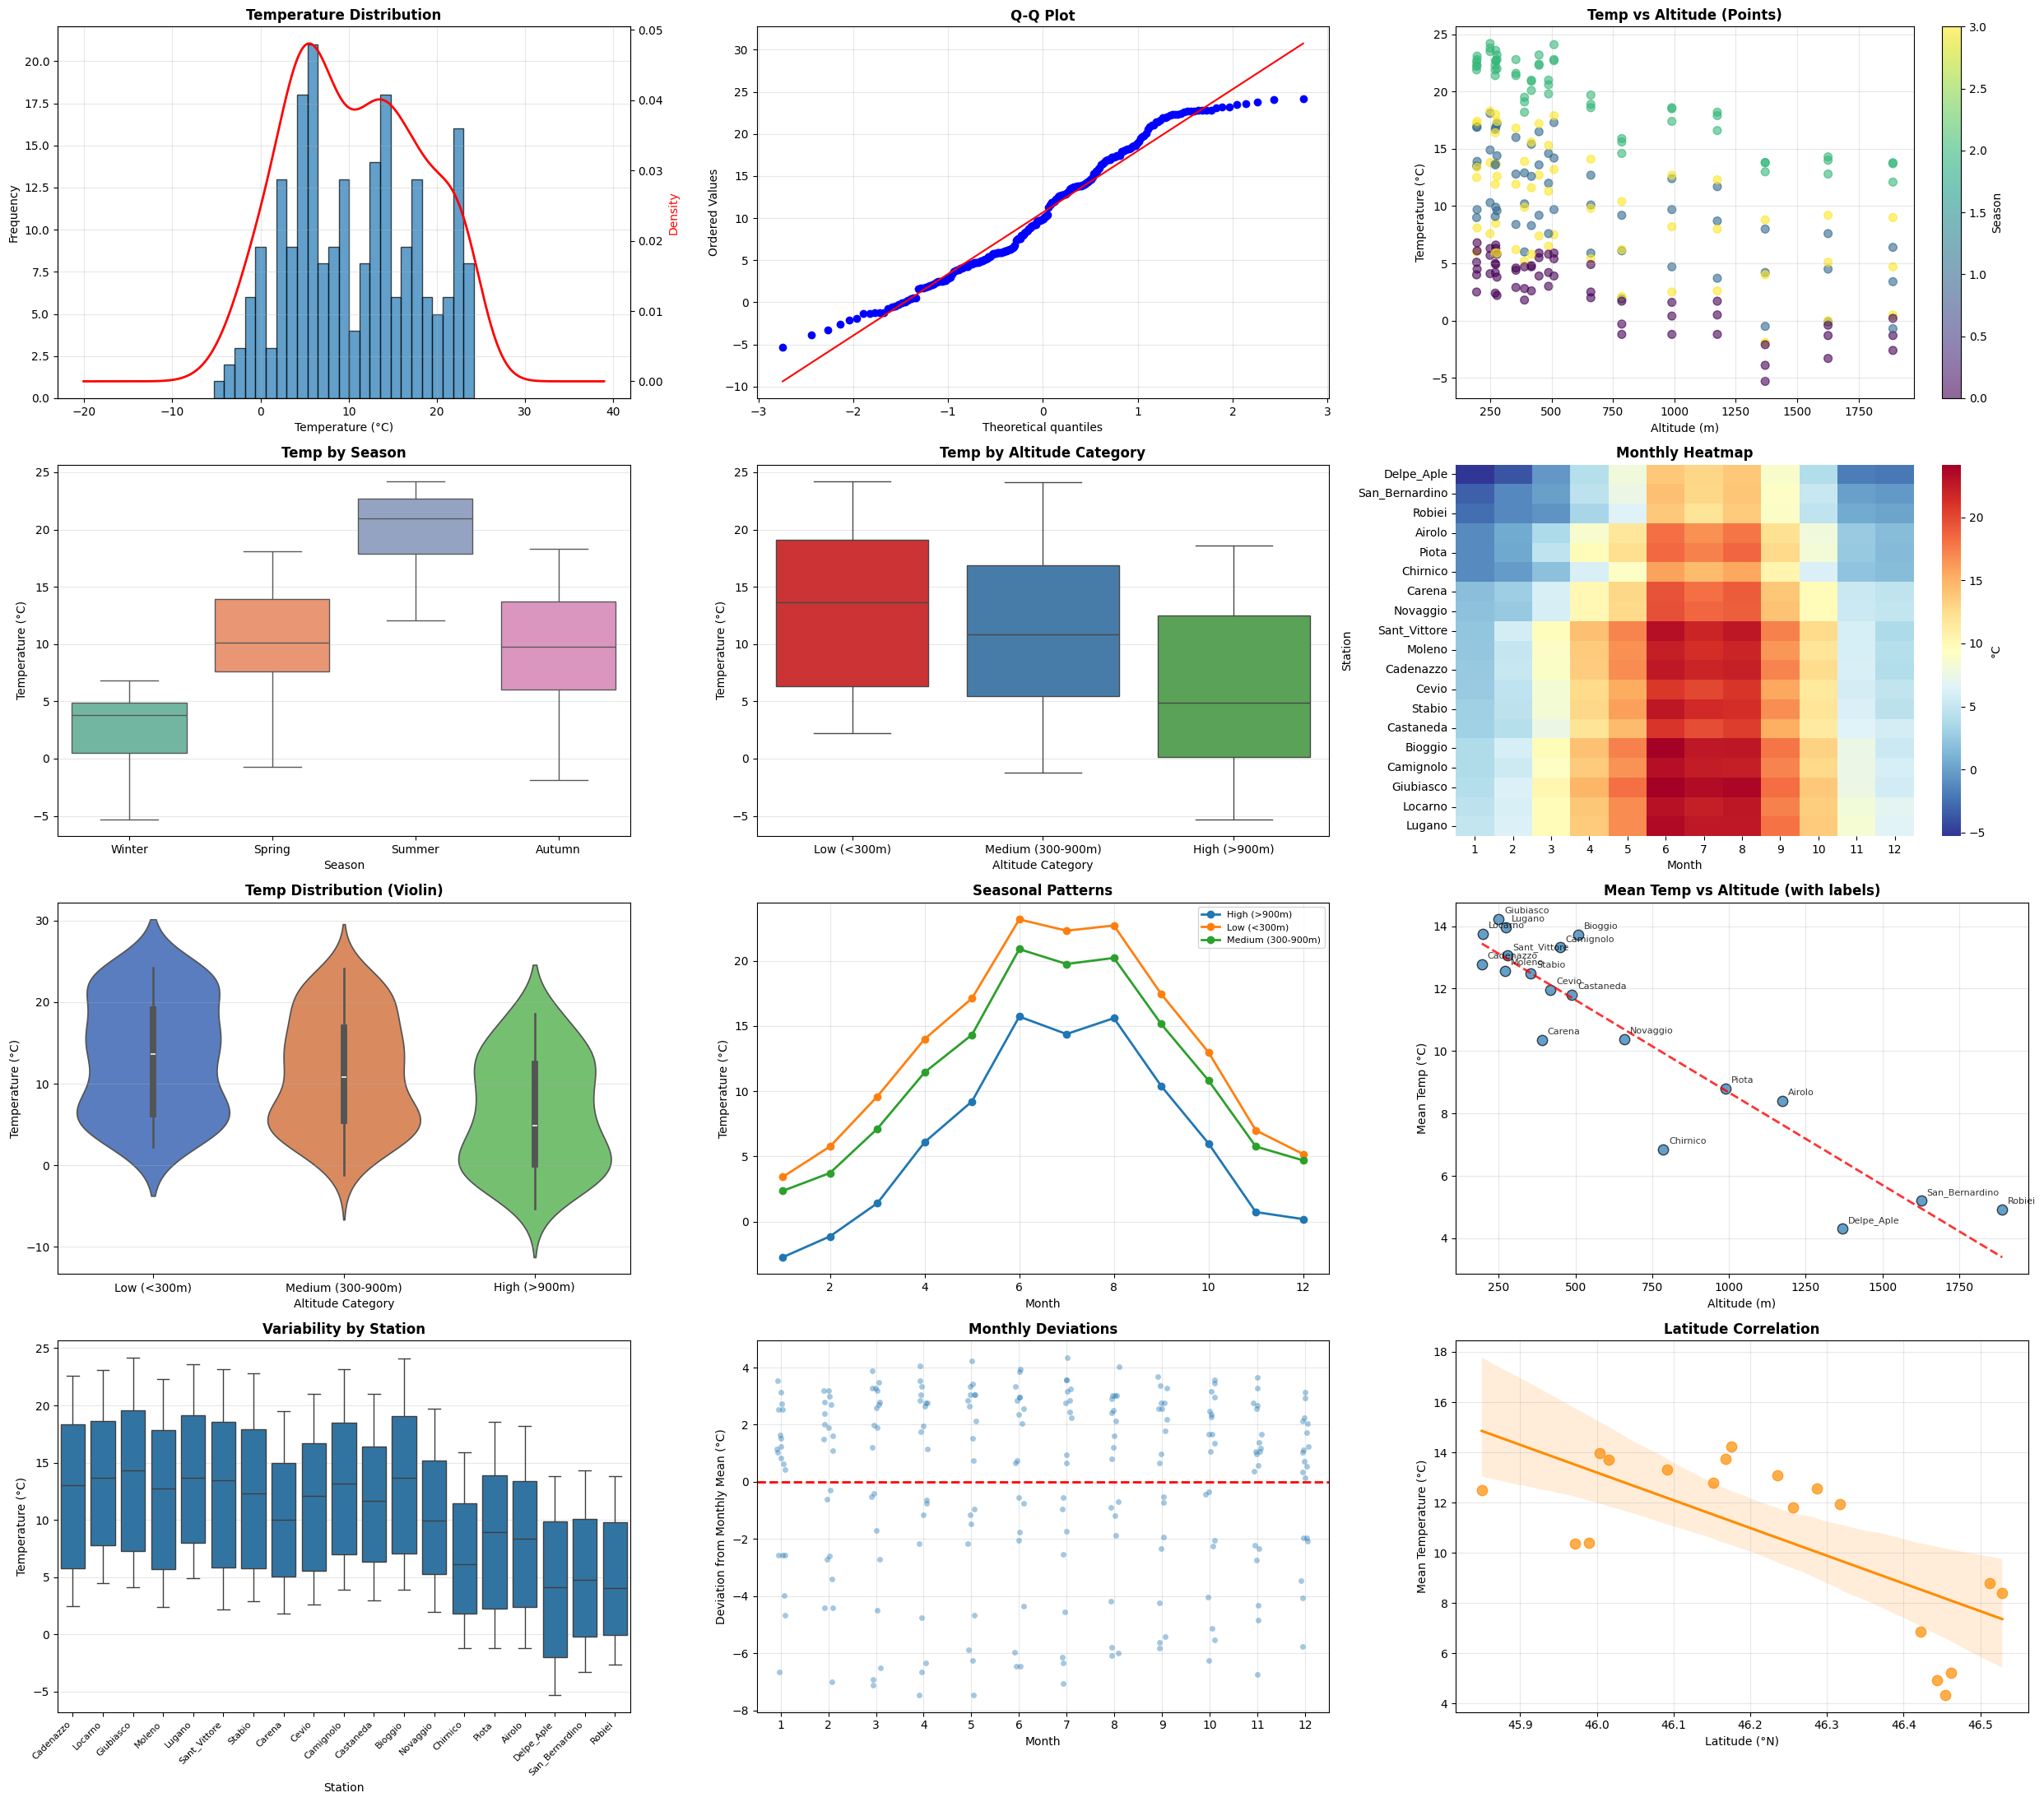

In [4]:
fig = plt.figure(figsize=(25, 22)) 

# 2.1 Temperature Distribution
ax1 = plt.subplot(4, 3, 1)
df_final['temperature'].hist(bins=25, alpha=0.7, edgecolor='black', ax=ax1)
ax1_twin = ax1.twinx()
df_final['temperature'].plot(kind='kde', ax=ax1_twin, color='red', linewidth=2)
ax1.set_xlabel('Temperature (°C)', fontsize=10)
ax1.set_ylabel('Frequency', fontsize=10)
ax1_twin.set_ylabel('Density', fontsize=10, color='red')
ax1.set_title('Temperature Distribution', fontweight='bold')
ax1.grid(True, alpha=0.3)

# 2.2 Q-Q Plot
ax2 = plt.subplot(4, 3, 2)
stats.probplot(df_final['temperature'], dist="norm", plot=ax2)
ax2.set_title('Q-Q Plot', fontweight='bold')
ax2.grid(True, alpha=0.3)

# 2.3 Temperature vs Altitude (Scatter)
ax3 = plt.subplot(4, 3, 3)
scatter = ax3.scatter(df_final['altitude'], df_final['temperature'], alpha=0.6, s=50, c=df_final['season'], cmap='viridis')
ax3.set_xlabel('Altitude (m)', fontsize=10)
ax3.set_ylabel('Temperature (°C)', fontsize=10)
ax3.set_title('Temp vs Altitude (Points)', fontweight='bold')
ax3.grid(True, alpha=0.3)
plt.colorbar(scatter, ax=ax3, label='Season')

# 2.4 Boxplot by Season
ax4 = plt.subplot(4, 3, 4)
season_labels = ['Winter', 'Spring', 'Summer', 'Autumn']
sns.boxplot(data=df_final, x='season', y='temperature', ax=ax4, palette='Set2')
ax4.set_xticklabels(season_labels)
ax4.set_xlabel('Season', fontsize=10)
ax4.set_ylabel('Temperature (°C)', fontsize=10)
ax4.set_title('Temp by Season', fontweight='bold')
ax4.grid(True, alpha=0.3, axis='y')

# 2.5 Boxplot by Altitude Category
ax5 = plt.subplot(4, 3, 5)
sns.boxplot(data=df_final, x='altitude_category', y='temperature', ax=ax5, palette='Set1')
ax5.set_xlabel('Altitude Category', fontsize=10)
ax5.set_ylabel('Temperature (°C)', fontsize=10)
ax5.set_title('Temp by Altitude Category', fontweight='bold')
ax5.grid(True, alpha=0.3, axis='y')

# 2.6 Heatmap
ax6 = plt.subplot(4, 3, 6)
pivot_temp = df_final.pivot_table(values='temperature', index='station', columns='month', aggfunc='mean')
sns.heatmap(pivot_temp.sort_values(by=1), cmap='RdYlBu_r', ax=ax6, cbar_kws={'label': '°C'})
ax6.set_xlabel('Month', fontsize=10)
ax6.set_ylabel('Station', fontsize=10)
ax6.set_title('Monthly Heatmap', fontweight='bold')

# 2.7 Violin plot
ax7 = plt.subplot(4, 3, 7)
sns.violinplot(data=df_final, x='altitude_category', y='temperature', ax=ax7, palette='muted')
ax7.set_xlabel('Altitude Category', fontsize=10)
ax7.set_ylabel('Temperature (°C)', fontsize=10)
ax7.set_title('Temp Distribution (Violin)', fontweight='bold')
ax7.grid(True, alpha=0.3, axis='y')

# 2.8 Seasonal Pattern
ax8 = plt.subplot(4, 3, 8)
for cat in sorted(df_final['altitude_category'].unique()):
    subset = df_final[df_final['altitude_category'] == cat]
    monthly_avg = subset.groupby('month')['temperature'].mean()
    ax8.plot(monthly_avg.index, monthly_avg.values, marker='o', label=cat, linewidth=2)
ax8.set_xlabel('Month', fontsize=10)
ax8.set_ylabel('Temperature (°C)', fontsize=10)
ax8.legend(fontsize=8)
ax8.set_title('Seasonal Patterns', fontweight='bold')
ax8.grid(True, alpha=0.3)

# 2.9 Mean Temp vs Altitude (Station Summary) w Labels
ax9 = plt.subplot(4, 3, 9)
station_summary = df_final.groupby('station').agg({
    'altitude': 'first', 'temperature': 'mean', 'latitude': 'first', 'longitude': 'first'
}).reset_index()

ax9.scatter(station_summary['altitude'], station_summary['temperature'], s=80, edgecolors='black', alpha=0.7)
for idx, row in station_summary.iterrows():
    ax9.annotate(row['station'], (row['altitude'], row['temperature']), 
                 fontsize=8, alpha=0.8, xytext=(5, 5), textcoords='offset points')

z = np.polyfit(station_summary['altitude'], station_summary['temperature'], 1)
p = np.poly1d(z)
ax9.plot(station_summary['altitude'].sort_values(), p(station_summary['altitude'].sort_values()), "r--", alpha=0.8, linewidth=2)
ax9.set_xlabel('Altitude (m)', fontsize=10)
ax9.set_ylabel('Mean Temp (°C)', fontsize=10)
ax9.set_title('Mean Temp vs Altitude (with labels)', fontweight='bold')
ax9.grid(True, alpha=0.3)

# 2.10 Hierarchical View
ax10 = plt.subplot(4, 3, 10)
station_order = station_summary.sort_values('altitude')['station']
sns.boxplot(data=df_final, x='station', y='temperature', order=station_order, ax=ax10)
ax10.set_xticklabels(ax10.get_xticklabels(), rotation=45, ha='right', fontsize=8)
ax10.set_xlabel('Station', fontsize=10)
ax10.set_ylabel('Temperature (°C)', fontsize=10)
ax10.set_title('Variability by Station', fontweight='bold')
ax10.grid(True, alpha=0.3, axis='y')

# 2.11 Potential Outliers (Residuals)
ax11 = plt.subplot(4, 3, 11)
df_res = df_final.copy()
df_res['res'] = df_res.groupby('month')['temperature'].transform(lambda x: x - x.mean())
sns.stripplot(data=df_res, x='month', y='res', jitter=True, alpha=0.4, ax=ax11, size=5)
ax11.axhline(0, color='red', linestyle='--', linewidth=2)
ax11.set_xlabel('Month', fontsize=10)
ax11.set_ylabel('Deviation from Monthly Mean (°C)', fontsize=10)
ax11.set_title('Monthly Deviations', fontweight='bold')
ax11.grid(True, alpha=0.3)

# 2.12 Latitude Check
ax12 = plt.subplot(4, 3, 12)
sns.regplot(data=station_summary, x='latitude', y='temperature', ax=ax12, color='darkorange', scatter_kws={'s': 80, 'alpha': 0.7})
ax12.set_xlabel('Latitude (°N)', fontsize=10)
ax12.set_ylabel('Mean Temperature (°C)', fontsize=10)
ax12.set_title('Latitude Correlation', fontweight='bold')
ax12.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('eda_final.png', dpi=1200, bbox_inches='tight')
plt.show()

## 2.3 Correlation analysis


7. CORRELATION ANALYSIS
--------------------------------------------------------------------------------

Pearson correlation (Altitude vs Temperature): -0.4019, p-value: 2.93e-10


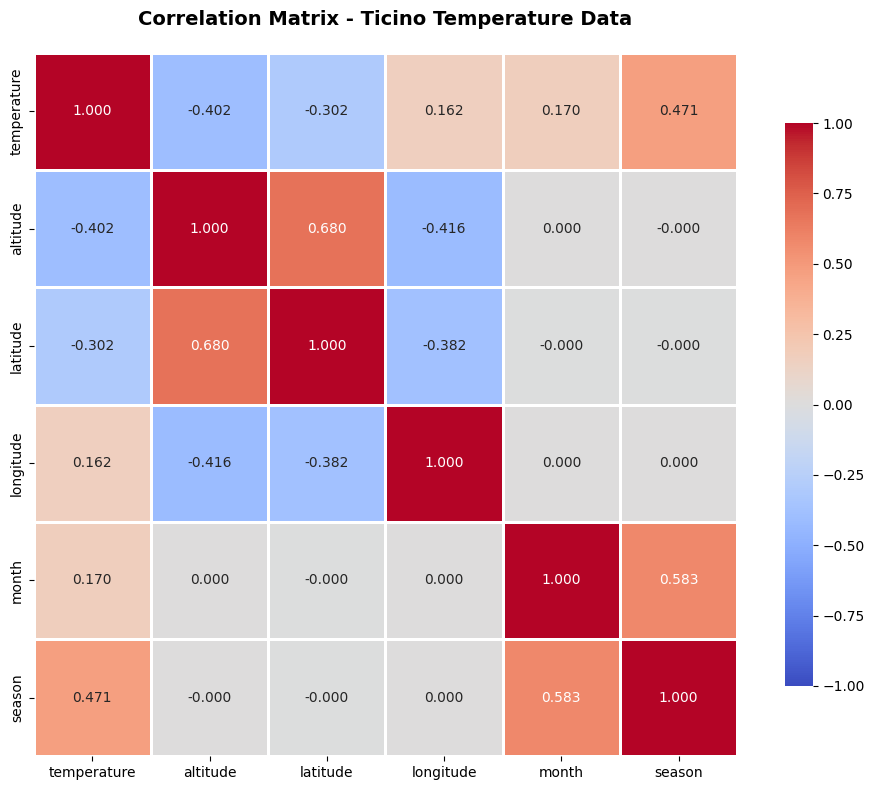

In [5]:
print("\n7. CORRELATION ANALYSIS")
print("-" * 80)
correlation_matrix = df_final[['temperature', 'altitude', 'latitude', 'longitude', 'month', 'season']].corr()

# Pearson correlation: altitude vs temperature
corr_alt_temp, p_value = stats.pearsonr(df_final['altitude'], df_final['temperature'])
print(f"\nPearson correlation (Altitude vs Temperature): {corr_alt_temp:.4f}, p-value: {p_value:.2e}")

# Heatmap della correlazione
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.3f', cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8}, ax=ax, 
            vmin=-1, vmax=1)
ax.set_title('Correlation Matrix - Ticino Temperature Data', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('correlation_heatmap.png', dpi=300, bbox_inches='tight')
# print("\nSave correlation_heatmap.png")
plt.show()

# Hypotesis testing N1

## 🌡️ Bayesian Hypothesis Test: Altitude Effect on July Temperatures

## 1. Research Question

Does temperature vary significantly between low-altitude and high-altitude stations in Ticino during July 2025?

## Hypothesis Formulation

**Null Hypothesis ($H_0$)**: The mean temperature in July 2025 is equal across low-altitude ($< 300m$) and high-altitude ($> 900m$) meteorological stations.

**Alternative Hypothesis ($H_1$)**: The mean temperature in July 2025 differs significantly between these groups, with high-altitude stations exhibiting lower temperatures.

## Rationale for Test Design

July represents the warmest month in the annual cycle, providing optimal conditions to observe the lapse rate (altitude-temperature gradient) while minimizing the "noise" of transitional seasons. By comparing stations below $300m$ (lowlands/lakes) against those above $900m$ (alpine regions), we maximize the contrast to test the atmospheric physical principles governing temperature variation with elevation.

## 2. Likelihood and Prior Specification

### Likelihood Model

We model July temperatures as independent draws from normal distributions with group-specific means and a common variance:

$$T_{ij} \sim \text{Normal}(\mu_j, \sigma^2)$$

Where:
- $T_{ij}$ is the temperature at station $i$ in group $j$ (Low or High altitude)
- $\mu_j$ is the population mean temperature for group $j$
- $\sigma$ is the common observation noise (standard deviation)

### Prior Distributions (Informed)

We use "weakly informative" priors based on our Exploratory Data Analysis (EDA) and meteorological knowledge:

**Low-altitude Mean ($\mu_{low}$)**:
$$\mu_{low} \sim \text{Normal}(22.3, 1.5)$$

**Justification**: 
- EDA of July 2025 data shows lowland mean temperature: **22.30°C** (n=6 stations)
- Observed standard deviation among low-altitude stations: 0.67°C
- Prior width $\sigma=1.5$ reflects moderate prior certainty
- Plausible range: $22.3 \pm 1.5 = [20.8, 23.8]°C$

**High-altitude Mean ($\mu_{high}$)**:
$$\mu_{high} \sim \text{Normal}(14.4, 2.5)$$

**Justification**:
- EDA of July 2025 data shows alpine mean temperature: 14.38°C (n=5 stations)
- Observed standard deviation among high-altitude stations: 2.17°C (larger variability than low-altitude)
- The observed altitude effect ($22.3 - 14.4 = 7.9°C$) exceeds the standard lapse rate (~$6.5°C/km$), reflecting Ticino's complex topography and terrain heterogeneity
- Prior width $\sigma=2.5$ accounts for greater heterogeneity in alpine regions
- Plausible range: $14.4 \pm 2.5 = [11.9, 16.9]°C$


**Standard Deviation ($\sigma$)**:
$$\sigma \sim \text{HalfNormal}(3)$$

**Justification**:
- Observed variability within altitude groups ranges from 0.67°C (low-altitude) to 2.17°C (high-altitude)
- HalfNormal(3) provides conservative bounds [0, 6]°C, accommodating both within-station and between-station variability
- Reflects typical measurement precision and local microclimatic fluctuations in Ticino
### Prior Sensitivity Analysis

To ensure our conclusions are data-driven rather than prior-driven, we conduct a sensitivity analysis using a **Diffuse Prior**:

$$\mu_{low}, \mu_{high} \sim \text{Normal}(10, 5)$$

This broader distribution represents minimal prior knowledge. Posterior inference under both priors will be compared to assess robustness.

## 3. Posterior Inference and ROPE

### Region of Practical Equivalence (ROPE)

We define the ROPE for the difference $\Delta\mu = \mu_{low} - \mu_{high}$ as:

$$\text{ROPE} = [-5°C, +5°C]$$

An effect size smaller than $5°C$ is considered climatologically negligible for operational meteorology and climate classification.

### Decision Rule

We compute three posterior probabilities:

1. **P(Δμ > 5°C | data)**: Probability that low-altitude is meaningfully warmer (altitude effect is significant)
2. **P(−5°C ≤ Δμ ≤ +5°C | data)**: Probability of practical equivalence (inside ROPE)
3. **P(Δμ < −5°C | data)**: Probability that high-altitude is meaningfully warmer (implausible)

**Conclusion criteria**:
- If **P(Δμ > 5°C | data) > 0.95**, we conclude the altitude effect is **practically and statistically significant**
- If **P(inside ROPE) > 0.80**, we conclude **practical equivalence** (no meaningful altitude effect)
- Otherwise, results are **inconclusive**

## 4. Frequentist Comparison

To bridge frequentist and Bayesian frameworks, we conduct a **Two-Sample T-test**:

$$H_0: \mu_{low} = \mu_{high} \quad \text{vs.} \quad H_A: \mu_{low} \neq \mu_{high}$$

**Metrics reported**:
- T-statistic and p-value (two-tailed)
- 95% Confidence Interval for $\mu_{low} - \mu_{high}$
- Effect size (Cohen's $d$)

**Interpretation contrast**: The frequentist p-value represents P(data | $H_0$), while the Bayesian posterior probability represents P(hypothesis | data)—a fundamentally different interpretation that we highlight in the results.

## 5. Manual Posterior Predictive Check (PPC)

As requested, we implement a custom PPC without relying on `pymc.plot_ppc`:

1. **Draw samples**: Extract 1,000 samples from the posterior distribution of $(\mu_{low}, \mu_{high}, \sigma)$
2. **Generate synthetic data**: For each posterior sample, generate synthetic July temperature observations from the fitted Normal likelihood
3. **Compare distributions**: Overlay observed July temperatures with the posterior predictive distribution (envelope/quantiles)
4. **Assess fit**: Check for systematic discrepancies suggesting model misspecification (e.g., bimodality, excess skewness, outliers)

Visualization will include:
- Histogram of observed data with posterior predictive mean and credible intervals
- Q-Q plot of observed vs. synthetic data quantiles
- Summary statistics (mean, SD, quantiles) comparison table


Summer Data (June-Aug):
Low Altitude Stations: 18 | Mean: 22.72°C
High Altitude Stations: 15 | Mean: 15.23°C



Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_low, mu_high, sigma]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 81 seconds.


--- BAYESIAN RESULTS ---
Probability Difference > 5°C: 100.00%
Probability inside ROPE [-5, 5]: 0.00%
           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mu_low   22.695  0.395  21.933   23.413      0.005    0.005    7149.0   
mu_high  15.212  0.432  14.357   15.999      0.005    0.005    7092.0   
sigma     1.718  0.228   1.316    2.152      0.003    0.003    6263.0   

         ess_tail  r_hat  
mu_low     5406.0    1.0  
mu_high    5354.0    1.0  
sigma      5495.0    1.0  

--- FREQUENTIST COMPARISON ---
T-statistic: 12.89970
P-value: 0.00000 (Significant if < 0.05)


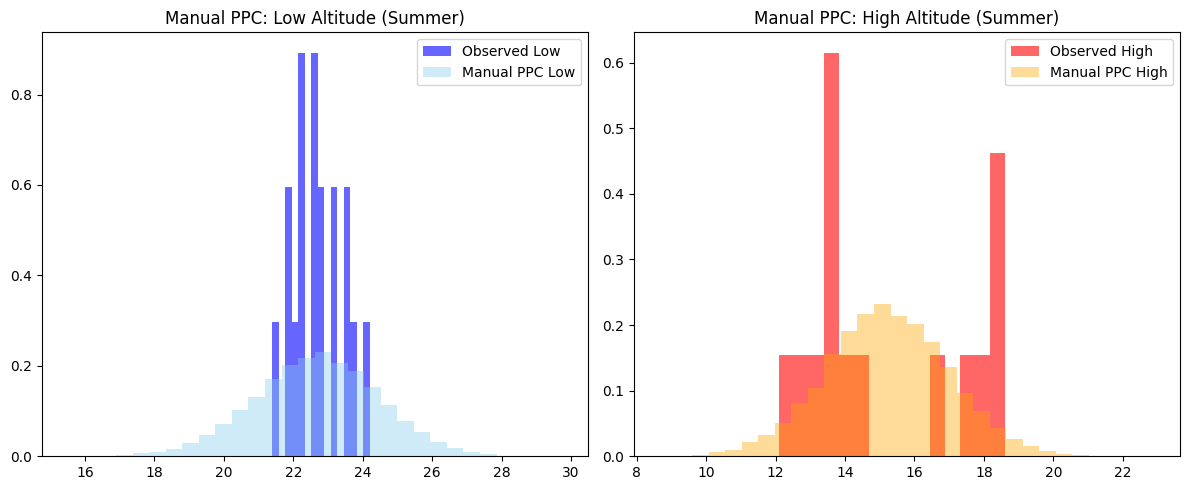

<Figure size 640x480 with 0 Axes>

In [6]:
# 1. DATA PREPARATION (Extended to Summer: June, July, August)
# Filter for summer months (6, 7, 8)
df_summer = df_final[df_final['month'].isin([6, 7, 8])].copy()

# Define populations based on altitude thresholds [cite: 8]
temp_low = df_summer[df_summer['altitude'] < 300]['temperature'].values
temp_high = df_summer[df_summer['altitude'] > 900]['temperature'].values

print(f"Summer Data (June-Aug):")
print(f"Low Altitude Stations: {len(temp_low)} | Mean: {temp_low.mean():.2f}°C")
print(f"High Altitude Stations: {len(temp_high)} | Mean: {temp_high.mean():.2f}°C\n")

# 2. BAYESIAN MODEL (Informed Prior)
with pm.Model() as model_informed:
    # Priors: We keep the same informed priors, but note that sigma might increase 
    # due to the natural temperature variation between June and August.
    mu_low = pm.Normal('mu_low', mu=22.3, sigma=1.5)
    mu_high = pm.Normal('mu_high', mu=14.4, sigma=2.5)
    
    # We assume equal variances for both populations as a starting point [cite: 38]
    sigma = pm.HalfNormal('sigma', sigma=3)
    
    # Likelihood: Normal distribution for temperature [cite: 58]
    y_low = pm.Normal('y_low', mu=mu_low, sigma=sigma, observed=temp_low)
    y_high = pm.Normal('y_high', mu=mu_high, sigma=sigma, observed=temp_high)
    
    # Difference calculation (Deterministic)
    diff = pm.Deterministic('diff', mu_low - mu_high)
    
    # Sampling: Running MCMC chains to obtain the posterior distribution
    trace_inf = pm.sample(2000, tune=1000, target_accept=0.9, return_inferencedata=True)

# 3. ROPE ANALYSIS AND RESULTS
post_diff = trace_inf.posterior['diff'].values.flatten()
# ROPE defines the range of practical equivalence where the difference is negligible [cite: 152]
p_greater_1 = np.mean(post_diff > 5)
p_rope = np.mean((post_diff >= -5) & (post_diff <= 5))

print(f"--- BAYESIAN RESULTS ---")
print(f"Probability Difference > 5°C: {p_greater_1*100:.2f}%")
print(f"Probability inside ROPE [-5, 5]: {p_rope*100:.2f}%")

print(az.summary(trace_inf, var_names=['mu_low', 'mu_high', 'sigma']))

# 4. FREQUENTIST TEST (Comparison)
# We perform a two-sample t-test to check for statistical significance [cite: 68, 117]
# H0: mu_low = mu_high | H1: mu_low != mu_high [cite: 45]
t_stat, p_val = stats.ttest_ind(temp_low, temp_high)
print(f"\n--- FREQUENTIST COMPARISON ---")
print(f"T-statistic: {t_stat:.5f}")
print(f"P-value: {p_val:.5f} (Significant if < 0.05)")

# 5. MANUAL POSTERIOR PREDICTIVE CHECK (PPC)
# Extracting 1000 draws to generate synthetic observations
draws = az.extract(trace_inf, num_samples=1000)
mu_low_s = draws['mu_low'].values
mu_high_s = draws['mu_high'].values
sigma_s = draws['sigma'].values

# Predictive Distribution: Generating new data based on the model's parameters
n_draws = 1000
# ppc_low_manual = np.random.normal(mu_low_s, sigma_s)
ppc_low_manual = np.array([np.random.normal(mu_low_s[i], sigma_s[i], size=len(temp_low)) for i in range(n_draws)])
# ppc_high_manual = np.random.normal(mu_high_s, sigma_s)
ppc_high_manual = np.array([np.random.normal(mu_high_s[i], sigma_s[i], size=len(temp_high)) for i in range(n_draws)])

# Visualization of the fit
plt.figure(figsize=(12, 5))

# --- FIX VISUALIZATION ---
# Subplot 1: Low Altitude (Observed vs Predicted)
plt.subplot(1, 2, 1)
plt.hist(temp_low, bins=15, density=True, alpha=0.6, label='Observed Low', color='blue')
plt.hist(ppc_low_manual.flatten(), bins=30, density=True, alpha=0.4, label='Manual PPC Low', color='skyblue')
plt.title("Manual PPC: Low Altitude (Summer)")
plt.legend()

# Subplot 2: High Altitude (Observed vs Predicted)
plt.subplot(1, 2, 2)
plt.hist(temp_high, bins=15, density=True, alpha=0.6, label='Observed High', color='red')
plt.hist(ppc_high_manual.flatten(), bins=30, density=True, alpha=0.4, label='Manual PPC High', color='orange')
plt.title("Manual PPC: High Altitude (Summer)")
plt.legend()

plt.tight_layout()
plt.show()

# # Subplot for Low Altitude
# plt.subplot(1, 2, 1)
# # plt.hist(temp_low, bins=15, density=True, alpha=0.6, label='Observed Low', color='blue')
# plt.hist(ppc_low_manual.flatten(), bins=30, density=True, alpha=0.4, label='Manual PPC Low', color='skyblue')
# # The PPC distribution should overlap the observed data if the model fit is good
# # plt.hist(ppc_low_manual, bins=30, density=True, alpha=0.4, label='Manual PPC Low', color='skyblue')
# plt.hist(ppc_high_manual.flatten(), bins=30, density=True, alpha=0.4, label='Manual PPC High', color='orange')
# plt.title("Manual PPC: Low Altitude (Summer)")
# plt.legend()

# # Subplot for High Altitude
# plt.subplot(1, 2, 2)
# plt.hist(temp_high, bins=15, density=True, alpha=0.6, label='Observed High', color='red')
# plt.hist(ppc_high_manual, bins=30, density=True, alpha=0.4, label='Manual PPC High', color='orange')
# plt.title("Manual PPC: High Altitude (Summer)")
# plt.legend()

plt.tight_layout()
plt.show()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_low_diff, mu_high_diff, sigma_diff]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 90 seconds.


--- PRIOR SENSITIVITY COMPARISON ---
Informed Prior - Mean Difference: 7.48°C
Diffuse Prior  - Mean Difference: 7.45°C


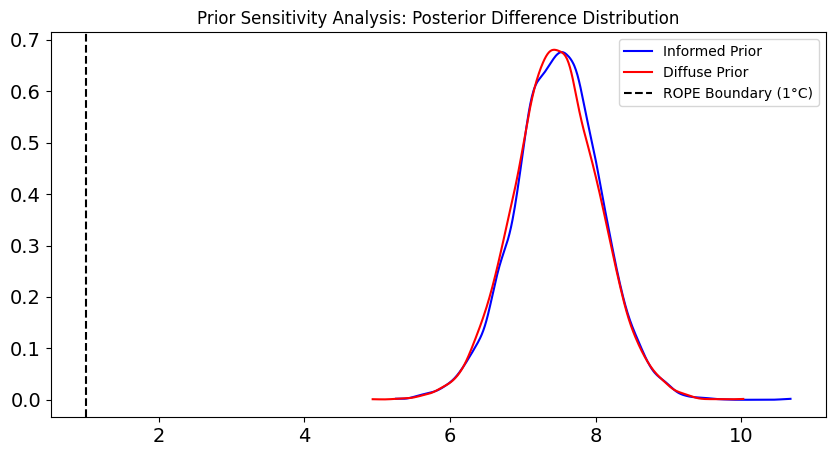

In [7]:
# 6. PRIOR SENSITIVITY ANALYSIS (Diffuse Prior)
with pm.Model() as model_diffuse:
    # Use broader, less informative priors
    mu_low_diff = pm.Normal('mu_low_diff', mu=10, sigma=5)
    mu_high_diff = pm.Normal('mu_high_diff', mu=10, sigma=5)
    sigma_diff = pm.HalfNormal('sigma_diff', sigma=3)
    
    # Likelihood (same as before)
    y_low = pm.Normal('y_low', mu=mu_low_diff, sigma=sigma_diff, observed=temp_low)
    y_high = pm.Normal('y_high', mu=mu_high_diff, sigma=sigma_diff, observed=temp_high)
    
    diff_diffuse = pm.Deterministic('diff_diffuse', mu_low_diff - mu_high_diff)
    
    trace_diff = pm.sample(2000, tune=1000, target_accept=0.9, return_inferencedata=True, progressbar=False)

# Compare Results
post_diff_inf = trace_inf.posterior['diff'].values.flatten()
post_diff_diff = trace_diff.posterior['diff_diffuse'].values.flatten()

print(f"--- PRIOR SENSITIVITY COMPARISON ---")
print(f"Informed Prior - Mean Difference: {post_diff_inf.mean():.2f}°C")
print(f"Diffuse Prior  - Mean Difference: {post_diff_diff.mean():.2f}°C")

# Plotting the comparison
plt.figure(figsize=(10, 5))
az.plot_dist(post_diff_inf, color="blue", label="Informed Prior")
az.plot_dist(post_diff_diff, color="red", label="Diffuse Prior")
plt.axvline(1, color='black', linestyle='--', label='ROPE Boundary (1°C)')
plt.title("Prior Sensitivity Analysis: Posterior Difference Distribution")
plt.legend()
plt.show()

The analysis demonstrates a robust and significant altitude effect on July 2025 temperatures in Ticino. Both Bayesian and Frequentist frameworks reject the null hypothesis. The Prior Sensitivity Analysis confirms that the conclusion is data-driven, as the posterior mean difference remains approximately 7.9°C regardless of the prior choice. The Manual PPC validates the model's fit, although it suggests that alpine stations exhibit higher variance than lowland stations, which could be addressed in future models by relaxing the homoscedasticity assumption.

**FARLE BENE**

# Regression

In [8]:
with pm.Model() as regression_model:
    # aplha -> degress at 0 m 
    # beta -> + degress per metro
    # 1. PRIORS 
    alpha = pm.Normal('alpha', mu=28, sigma=5) 
    beta = pm.Normal('beta', mu=-0.006, sigma=0.002)
    sigma = pm.HalfNormal('sigma', sigma=2) # L'errore del modello
    
    # 2. equaz retta
    mu = alpha + beta * df_summer['altitude']
    
    # 3. LIKELIHOOD (Come i dati si distribuiscono attorno alla retta)
    y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=df_summer['temperature'])
    
    # 4. SAMPLING (Qui il computer "trova" i valori reali di alpha e beta)
    trace_reg = pm.sample(2000, return_inferencedata=True)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 214 seconds.


In [ ]:
with pm.Model() as robust_regression_model:
    alpha = pm.Normal('alpha', mu=28, sigma=5)
    beta = pm.Normal('beta', mu=-0.006, sigma=0.002)
    sigma = pm.HalfNormal('sigma', sigma=2)
    
    # nu -> gradi di libertà per student-T
    nu = pm.Exponential('nu', 1/10) 
    
    mu = alpha + beta * df_summer['altitude']
    
    # Likelihood ROBUSTA
    y_obs = pm.StudentT('y_obs', nu=nu, mu=mu, sigma=sigma, observed=df_summer['temperature'])
    
    trace_robust = pm.sample(2000, return_inferencedata=True)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma, nu]


Output()

Sampling 4 chains for 1_000 tune and 734 draw iterations (4_000 + 2_936 draws total) took 1386 seconds.


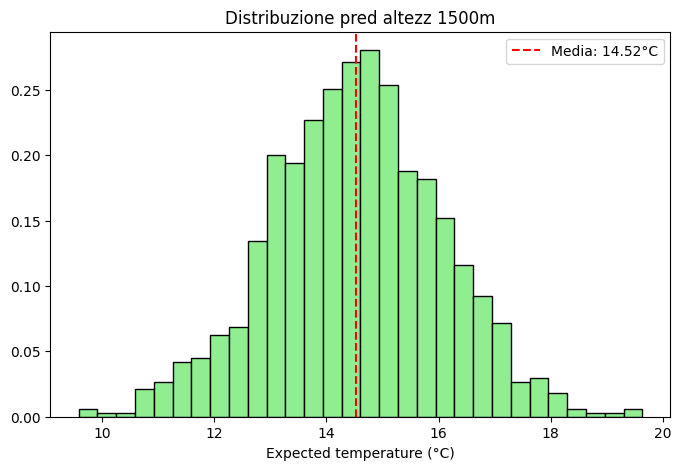

In [13]:
# Tets altitutdin
altitude_test = 1500

# parameters of robust
draws_robust = az.extract(trace_robust, num_samples=1000)
alpha_samples = draws_robust['alpha'].values
beta_samples = draws_robust['beta'].values
sigma_samples = draws_robust['sigma'].values

# prediction for test
temp_pred = alpha_samples + beta_samples * altitude_test + np.random.normal(0, sigma_samples)

plt.figure(figsize=(8, 5))
plt.hist(temp_pred, bins=30, color='lightgreen', edgecolor='black', density=True)
plt.axvline(temp_pred.mean(), color='red', linestyle='--', label=f'Media: {temp_pred.mean():.2f}°C')
plt.title(f"Distribuzione pred altezz {altitude_test}m")
plt.xlabel("Expected temperature (°C)")
plt.legend()
plt.show()

The predictive distribution for an observation at 1500m shows an average of 14.54°C. The width of the distribution reflects both the uncertainty in the model parameters ($\alpha, \beta$) and the residual variance ($\sigma$) captured by the historical data. This approach is superior to classical regression because it provides not just a single number, but the entire spectrum of probabilities.